<a href="https://colab.research.google.com/github/ymoslem/OpenNMT-Tutorial/blob/main/1-NMT-Data-Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Gathering and Processing 

To build a Machine Translation system, you need bilingual data, i.e. source sentences and their translations. You can use public bilingual corpora/datasets or you can use your translation memories (TMs). However, NMT requires a lot of data to train a good model, that is why most companies start with training a strong baseline model using public bilingual datasets, and then fine-tune this baseline model on their TMs. Sometimes also you can use pre-trained models directly for fine-tuning.

The majority of public bilingual datasets are collected on OPUS: https://opus.nlpl.eu/

Most of the datasets can be used for both commercial and non-commercial uses; however, some of them have more restricted licences. So you have to double-check the licence of a dataset before using it.

On OPUS, go to “Search & download resources” and choose two languages from the drop-down lists. You will see how it will list the available language datasets for this language pair. Try to use non-variant language codes like “en” for English and “fr” for French to get all the variants under this language. To know more details about a specific dataset, click its name.

In Machine Translation, we use the “Moses” format. Go ahead and try to download the “tico-19 v2020-10-28” by clicking “moses”. This will download a *.zip file; when you extract it, the two files that you care about are those whose names ending by the language codes. For example, for English to French, you will have “tico-19.en-fr.en” and “tico-19.en-fr.fr“. You can open these files with any text editor. Each file has a sentence/segment per line, and it is matching translation in the same line in the other file. This is what the "Moses" file format means.

Note that not all datasets are of the same quality. Some datasets have lower quality, especially big corpora crawled from the web. Check the provided “sample” before using the dataset. Nevertheless, even high-quality datasets, like those from the UN and EU, require filtering.



In [1]:
# Create a directory and clone the Github MT-Preparation repository
!mkdir nmt
%cd nmt
!git clone https://github.com/OrianeN/MT-Preparation.git

/mnt/c/Users/onedey/OneDrive - AMPLEXOR/Documents/OtherGits/OpenNMT-Tutorial-onedey/nmt
Cloning into 'MT-Preparation'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (200/200), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 200 (delta 102), reused 189 (delta 96), pack-reused 0
Receiving objects: 100% (200/200), 48.25 KiB | 5.36 MiB/s, done.
Resolving deltas: 100% (102/102), done.


In [2]:
# Install the requirements
!pip3 install -r MT-Preparation/requirements.txt

# Datasets

Example datasets:

* EN-AR: https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/ar-en.txt.zip
* EN-ES: https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/en-es.txt.zip
* EN-FR: https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/en-fr.txt.zip
* EN-RU: https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/en-ru.txt.zip
* EN-ZH: https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/en-zh.txt.zip

In [3]:
# Download and unzip a dataset
!wget https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/en-fr.txt.zip
!unzip en-fr.txt.zip

--2022-09-08 11:03:20--  https://object.pouta.csc.fi/OPUS-UN/v20090831/moses/en-fr.txt.zip
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18, 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10014972 (9.6M) [application/zip]
Saving to: ‘en-fr.txt.zip’

en-fr.txt.zip       100%[===================>]   9.55M  12.6MB/s    in 0.8s    

2022-09-08 11:03:21 (12.6 MB/s) - ‘en-fr.txt.zip’ saved [10014972/10014972]

Archive:  en-fr.txt.zip
  inflating: UN.en-fr.en             
  inflating: UN.en-fr.fr             
  inflating: README                  


# Data Filtering

Filtering out low-quality segments can help improve the translation quality of the output MT model. This might include misalignments, empty segments, duplicates, among other issues. 

In [4]:
# Filter the dataset
!paste UN.en-fr.fr UN.en-fr.en > UN.en-fr
# Arguments: bilingual file, source file, target file, source language, target language
!python3 MT-Preparation/filtering/filter.py UN.en-fr fr en

Dataframe shape (rows, columns): (74067, 2)
--- Rows with Empty Cells Deleted	--> Rows: 74067
--- Duplicates Deleted			--> Rows: 60662
--- Source-Copied Rows Deleted		--> Rows: 60476
--- Too Long Source/Target Deleted	--> Rows: 59719
--- HTML Removed			--> Rows: 59719
--- Rows will remain in true-cased	--> Rows: 59719
--- Rows with Empty Cells Deleted	--> Rows: 59719
--- Rows Shuffled			--> Rows: 59719
--- Source Saved: UN.en-fr.fr-filtered.fr
--- Target Saved: UN.en-fr.en-filtered.en


# Tokenization / Sub-wording

To build a vocabulary for any NLP model, you have to tokenize (i.e. split) sentences into smaller units. Word-based tokenization used to be the way to go; in this case, each word would be a token. However, an MT model can only learn a specific number of vocabulary tokens due to limited hardware resources. To solve this issue, sub-words are used instead of whole words. At the translation time, when the model sees a new word/token that looks like a word/token it has in the vocabulary, it still can try to continue the translation instead of marking this word as “unknown” or “unk”.

There are a few approaches to sub-wording such as BPE and the unigram model. One of the famous toolkits that incorporates the most common approaches is [SentencePiece](https://github.com/google/sentencepiece). Note that you have to train a sub-wording model and then use it. After translation, you will have to “desubword” or “decode” your text back using the same SentencePiece model.



In [5]:
!ls MT-Preparation/subwording/

1-train_bpe.py	1-train_unigram.py  2-subword.py  3-desubword.py


In [6]:
# Train a SentencePiece model for subword tokenization
!python MT-Preparation/subwording/1-train_unigram.py UN.en-fr.fr-filtered.fr UN.en-fr.en-filtered.en

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=UN.en-fr.fr-filtered.fr --model_prefix=source --vocab_size=50000 --hard_vocab_limit=false --split_digits=true
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: UN.en-fr.fr-filtered.fr
  input_format: 
  model_prefix: source
  model_type: UNIGRAM
  vocab_size: 50000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 1
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 0
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_

In [7]:
!ls

MT-Preparation	UN.en-fr.en		 UN.en-fr.fr-filtered.fr  source.vocab
README		UN.en-fr.en-filtered.en  en-fr.txt.zip		  target.model
UN.en-fr	UN.en-fr.fr		 source.model		  target.vocab


In [8]:
# Subword the dataset
!python3 MT-Preparation/subwording/2-subword.py source.model target.model UN.en-fr.fr-filtered.fr UN.en-fr.en-filtered.en

Source Model: source.model
Target Model: target.model
Source Dataset: UN.en-fr.fr-filtered.fr
Target Dataset: UN.en-fr.en-filtered.en
Done subwording the source file! Output: UN.en-fr.fr-filtered.fr.subword
Done subwording the target file! Output: UN.en-fr.en-filtered.en.subword


In [9]:
# First 3 lines before subwording
!head -n 3 UN.en-fr.fr-filtered.fr && echo "-----" && head -n 3 UN.en-fr.en-filtered.en

3. Réaffirme l'importance du Plan de mise en œuvre de Johannesburg en ce qui concerne les ressources halieutiques, en particulier l'engagement qui y est pris de reconstituer d'urgence les stocks de poissons en voie d'épuisement, si possible d'ici à 2015Voir Rapport du Sommet mondial pour le développement durable, Johannesburg (Afrique du Sud), 26 août-4 septembre 2002 (publication des Nations Unies, numéro de vente : F.03.II.A.1), chap. I, résolution 2, annexe, par. 31, a. ;
11. Prend note de l'accord intervenu en mars 2003 - et en cours de révision - entre le Gouvernement guatémaltèque et le Médiateur pour les droits de l'homme, avec l'appui de la société civile, en vue de créer une Commission d'enquête sur les groupes illégaux et les services de sécurité clandestins ;
Rappelant le chapitre 36 d'Action 21 relatif à la promotion de l'éducation, de la sensibilisation du public et de la formation, adopté par la Conférence des Nations Unies sur l'environnement et le développement, tenue à

In [10]:
# First 3 lines after subwording
!head -n 3 UN.en-fr.fr-filtered.fr.subword && echo "---" && head -n 3 UN.en-fr.en-filtered.en.subword

▁ 3 . ▁Réaffirme ▁l ' importance ▁du ▁Plan ▁de ▁mise ▁en ▁œuvre ▁de ▁Johannesburg ▁en ▁ce ▁qui ▁concerne ▁les ▁ressources ▁halieutiques , ▁en ▁particulier ▁l ' engagement ▁qui ▁y ▁est ▁pris ▁de ▁reconstitu er ▁d ' urgence ▁les ▁stocks ▁de ▁poissons ▁en ▁voie ▁d ' épuisement , ▁si ▁possible ▁d ' ici ▁à ▁ 2 0 1 5 Voir ▁Rapport ▁du ▁Sommet ▁mondial ▁pour ▁le ▁développement ▁durable , ▁Johannesburg ▁( Afrique ▁du ▁Sud ), ▁ 2 6 ▁août - 4 ▁septembre ▁ 2 0 0 2 ▁( publication ▁des ▁Nations ▁Unies , ▁numéro ▁de ▁vente ▁: ▁F . 0 3 . II . A . 1 ), ▁chap . ▁I , ▁résolution ▁ 2 , ▁annexe , ▁par . ▁ 3 1 , ▁a . ▁;
▁ 1 1 . ▁Prend ▁note ▁de ▁l ' accord ▁intervenu ▁en ▁mars ▁ 2 0 0 3 ▁ - ▁et ▁en ▁cours ▁de ▁révision ▁ - ▁entre ▁le ▁Gouvernement ▁guatémaltèque ▁et ▁le ▁Médiat eur ▁pour ▁les ▁droits ▁de ▁l ' homme , ▁avec ▁l ' appui ▁de ▁la ▁société ▁civile , ▁en ▁vue ▁de ▁créer ▁une ▁Commission ▁d ' enquête ▁sur ▁les ▁groupes ▁illégaux ▁et ▁les ▁services ▁de ▁sécurité ▁clandestins ▁;
▁Rappelant ▁le ▁chap

# Data Splitting

We usually split our dataset into 3 portions:

1. training dataset - used for training the model;
2. development dataset - used to run regular validations during the training to help improve the model parameters; and
3. testing dataset - a holdout dataset used after the model finishes training to finally evaluate the model on unseen data.

In [13]:
# Split the dataset into training set, development set, and test set
!paste UN.en-fr.fr-filtered.fr.subword UN.en-fr.en-filtered.en.subword > UN.en-fr.filtered.subword
# Development and test sets should be between 1000 and 5000 segments (here we chose 2000)
!python MT-Preparation/train_dev_split/train_dev_test_split.py 2000 2000 UN.en-fr.filtered.subword fr en

Dataframe shape: (59719, 2)
--- Empty Cells Deleted --> Rows: 59719
--- Wrote Files
Done!
Output files
UN.en-fr.filtered.subword.fr.train
UN.en-fr.filtered.subword.en.train
UN.en-fr.filtered.subword.fr.dev
UN.en-fr.filtered.subword.en.dev
UN.en-fr.filtered.subword.fr.test
UN.en-fr.filtered.subword.en.test


In [14]:
# Line count for the subworded train, dev, test datatest
!wc -l *.subword.*

    2000 UN.en-fr.filtered.subword.en.dev
    2000 UN.en-fr.filtered.subword.en.test
   55719 UN.en-fr.filtered.subword.en.train
    2000 UN.en-fr.filtered.subword.fr.dev
    2000 UN.en-fr.filtered.subword.fr.test
   55719 UN.en-fr.filtered.subword.fr.train
  119438 total


In [15]:
# Check the first and last line from each dataset

# -------------------------------------------
# Change this cell to print your name
!echo -e "My name is: FirstName SecondName \n"
# -------------------------------------------

!echo "---First line---"
!head -n 1 *.{train,dev,test}

!echo -e "\n---Last line---"
!tail -n 1 *.{train,dev,test}

My name is: FirstName SecondName 

---First line---
==> UN.en-fr.filtered.subword.en.train <==
▁ 3 . ▁Reaffirms ▁the ▁importance ▁of ▁the ▁Johannesburg ▁Plan ▁of ▁Implementation ▁in ▁relation ▁to ▁fisheries , ▁in ▁particular ▁the ▁commitment ▁made ▁therein ▁to ▁restore ▁deplet ed ▁fish ▁stocks ▁on ▁an ▁urgent ▁basis ▁and , ▁where ▁possible , ▁not ▁later ▁than ▁ 2 0 1 5 ; See ▁Report ▁of ▁the ▁World ▁Summit ▁on ▁S ustainable ▁Development , ▁Johannesburg , ▁South ▁Africa , ▁ 2 6 ▁August - 4 ▁September ▁ 2 0 0 2 ▁( Unit ed ▁Nations ▁publication , ▁Sales ▁No . ▁E . 0 3 . II . A . 1 ▁and ▁corrigendum ), ▁chap . ▁I , ▁resolution ▁ 2 , ▁annex , ▁para . ▁ 3 1 ▁( a ).

==> UN.en-fr.filtered.subword.fr.train <==
▁ 3 . ▁Réaffirme ▁l ' importance ▁du ▁Plan ▁de ▁mise ▁en ▁œuvre ▁de ▁Johannesburg ▁en ▁ce ▁qui ▁concerne ▁les ▁ressources ▁halieutiques , ▁en ▁particulier ▁l ' engagement ▁qui ▁y ▁est ▁pris ▁de ▁reconstitu er ▁d ' urgence ▁les ▁stocks ▁de ▁poissons ▁en ▁voie ▁d ' épuisement , ▁si ▁possib

# Mount your drive to save your data

Click the folder icon to the left, and then click the Google Drive icon.

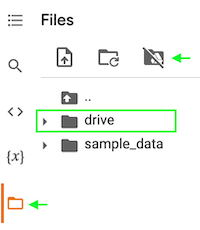

In [ ]:
# Move your data to your Google Drive
%cd ..
!mv nmt drive/MyDrive/

/content
mv: inter-device move failed: 'nmt' to 'drive/MyDrive/nmt'; unable to remove target: Directory not empty
